# Simulated data

- Input time series are taken from Pully, Lugano and Basel.

- Streamflow time series have been obtained by running the threebox model with parameters calibrated with real data from similar sites. Namely:

### Calibration for Pully (using the site with GISID 81)
bu <- 50.      # upper box drainage exponent

bl <- 1.          # lower box drainage exponent

bc <- 1.5          # channel box drainage exponent (FIXED at 1.5 by hydraulic geometry)

su_ref <- 335     # upper box reference storage

sl_ref <- 32    # lower box reference storage

sc_ref <- 2.83     # channel box storage

fw <- 1.13          # fraction of upper box storage over which ET responds to storage level

pet_mult <- 0.8   # PET multiplier

f_OF <- 0.26      # fraction of discharge in reference state from overland flow

f_SS <- 0.24       # fraction of discharge in reference state from shallow subsurface flow


### Calibration for Lugano (using the site with GISID 58)
bu <- 50.      # upper box drainage exponent

bl <- 2.24          # lower box drainage exponent

bc <- 1.5          # channel box drainage exponent (FIXED at 1.5 by hydraulic geometry)

su_ref <- 294.83     # upper box reference storage

sl_ref <- 24    # lower box reference storage

sc_ref <- 1.74     # channel box storage

fw <- 1.06          # fraction of upper box storage over which ET responds to storage level

pet_mult <- 0.8   # PET multiplier

f_OF <- 0.13      # fraction of discharge in reference state from overland flow

f_SS <- 0.55       # fraction of discharge in reference state from shallow subsurface flow




### Calibration for Basel (using the site with GISID 25 BAFU 2199)
bu <- 50.      # upper box drainage exponent

bl <- 3.617         # lower box drainage exponent

bc <- 1.5          # channel box drainage exponent (FIXED at 1.5 by hydraulic geometry)

su_ref <- 217.84     # upper box reference storage

sl_ref <- 61.6    # lower box reference storage

sc_ref <- 4.11     # channel box storage

fw <- 1.12          # fraction of upper box storage over which ET responds to storage level

pet_mult <- 0.8   # PET multiplier

f_OF <- 0.33      # fraction of discharge in reference state from overland flow

f_SS <- 0.298       # fraction of discharge in reference state from shallow subsurface flow




#### For the FLASHY setting: I use exactly the model parameters obtained from the calibration

#### For the Not FLASHY setting: I use the model parameters obtained from the calibration except for:
- su_ref: which is multiplied by 2
- bu: which is divided by 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/tmp/ipykernel_5161/328324305.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ls_stations = ['Pully', 'Lugano', 'Basel']
ls_modes = ['flashy', 'notflashy']

In [3]:
def show_data(df, max_time_points=24*365, title=None):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    precipitation = df['p'][-max_time_points:]
    dates = df['t'][-max_time_points:]
    pet = df['pet'][-max_time_points:]
    streamflow = df['q'][-max_time_points:]
    # Plot precipitation with inverted y-axis on the first axis
    ax1.plot(dates, precipitation, color='blue', alpha=0.6, label='Precipitation')
    ax1.invert_yaxis()  # Invert the y-axis to make precipitation start from the top
    ax1.set_ylabel('Precipitation (mm)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xlabel('Date')
    
    # Create a second y-axis for PET
    ax2 = ax1.twinx()
    ax2.plot(dates, pet, color='green', label='PET')
    
    ax2.plot(dates, streamflow, color='orange', label='Streamflow')
    # Add a legend to the plot
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
        
    # Adjust layout to avoid overlap
    fig.tight_layout()
    if not(title is None):
        plt.title(title)
    # Display the plot
    plt.show()

In [4]:
def show_transfer_functions(data, site, max_lag=24*3, title=None, K=4):
    tfs = np.load('{0}_transfer.npy'.format(site))
    plt.figure(1)
    plt.plot([i/24 for i in range(max_lag)], np.mean(tfs, axis=0)[:max_lag])
    plt.xlabel('Lag (in Days)', fontsize=14)
    plt.ylabel('Global NRF', fontsize=14)
    if not(title is None):
        plt.title(title, fontsize=14)
    plt.show()

    lst_tfs = np.load('{0}_lst_transfer.npy'.format(site))[:tfs.shape[0]]
    precipitation = data['p'].iloc[np.array([el-1 for el in lst_tfs])] # -1 since the index have been saved from R where indexes start at 1 and not 0 as in python
    n = len(precipitation)
    sorted_precip = np.sort(precipitation)
    low = np.min(sorted_precip)
    precip_ranges = []
    for k in range(K):
        up = sorted_precip[min(int(n * (k+1)/K), n-1)]
        precip_ranges.append([low,up])
        low = up

    colors = ['red', 'orange', 'cyan', 'blue']
    plt.figure(2)
    for k in range(K):
        low,up = precip_ranges[k]
        idxs = np.where((low<=precipitation) & (precipitation<up))[0]
        average_tf = np.mean(tfs[idxs,:], axis=0)
        if k==K-1:
            up = 'max'
        plt.plot([i/24 for i in range(max_lag)], average_tf[:max_lag], label='{0}-{1}'.format(low,up), c=colors[k])
    plt.legend(title='Precipitation range')
    plt.xlabel('Lag (in Days)', fontsize=14)
    plt.ylabel('NRF startified by precipitation intensity', fontsize=14)
    if not(title is None):
        plt.title(title, fontsize=14)
    plt.show()

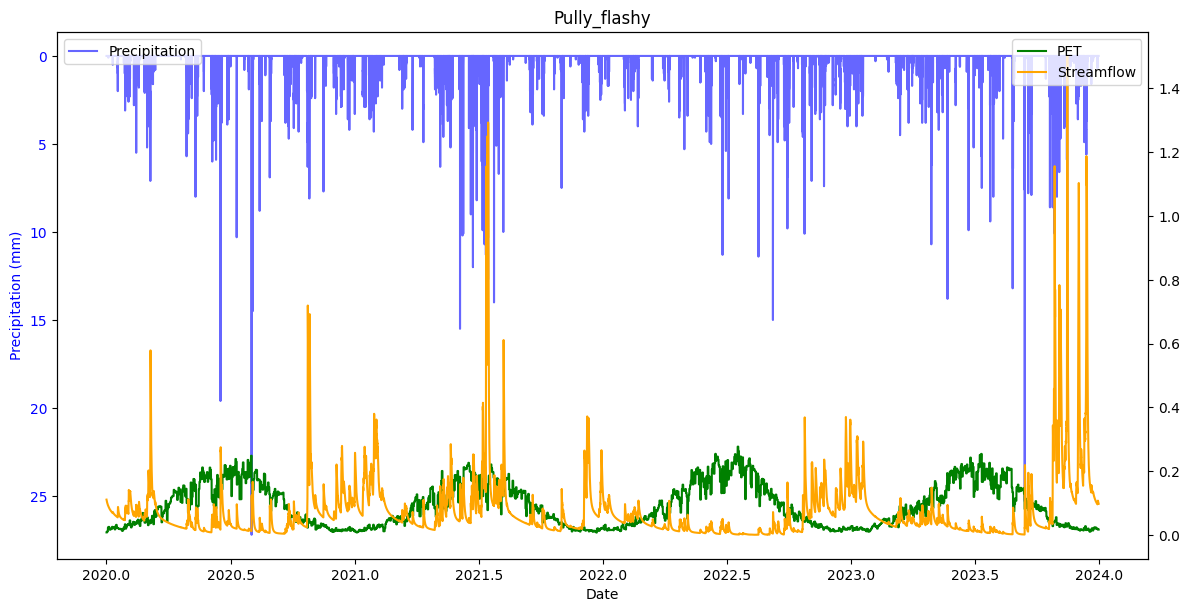

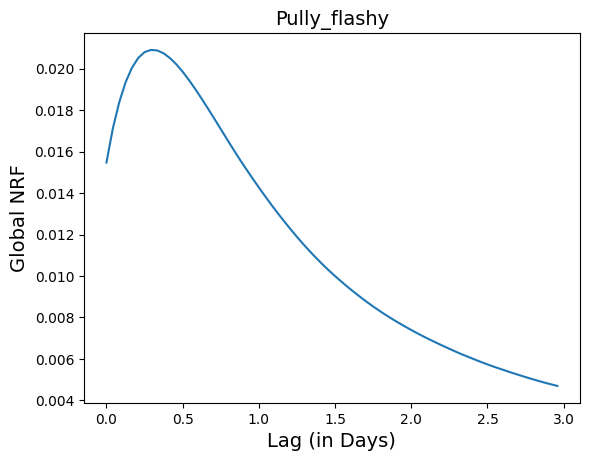

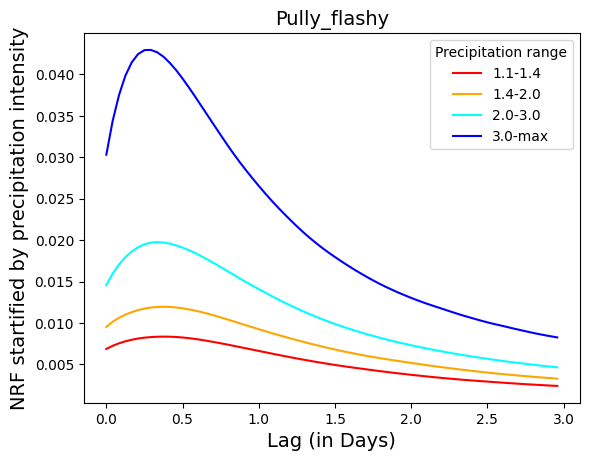

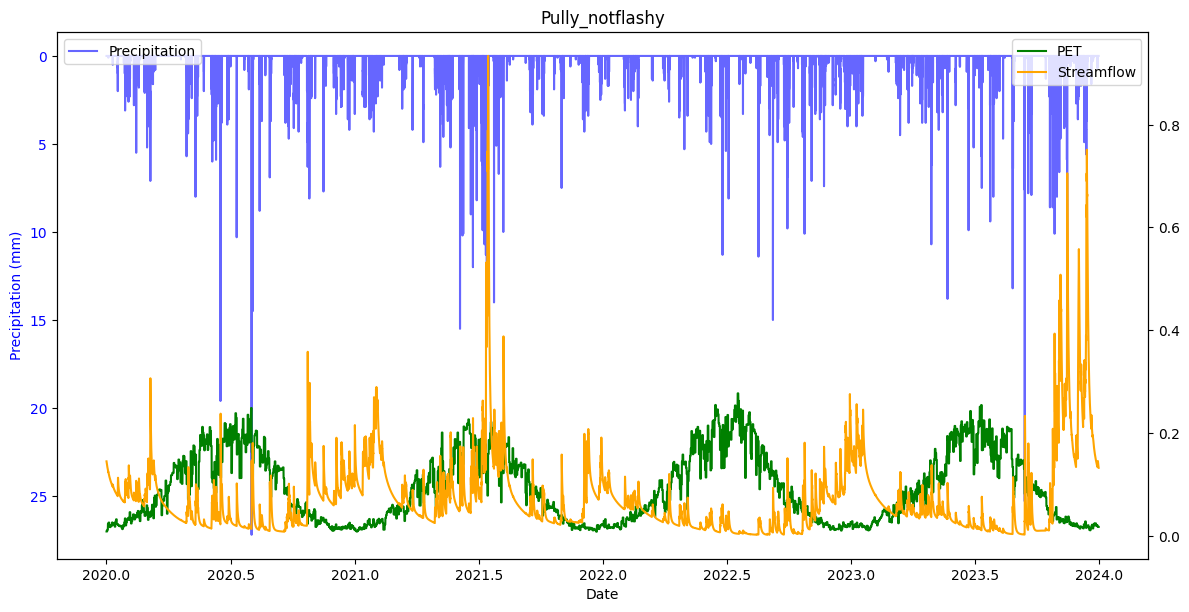

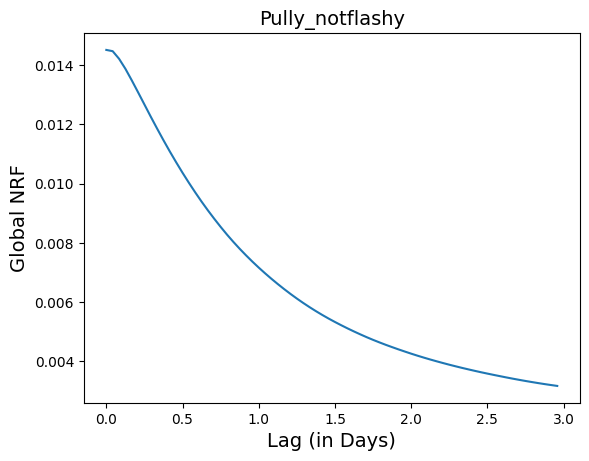

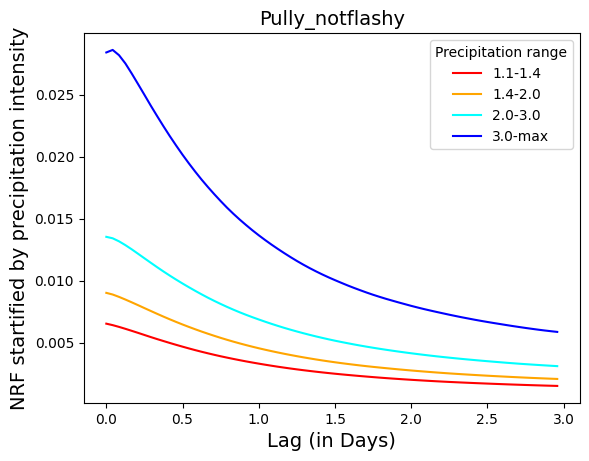

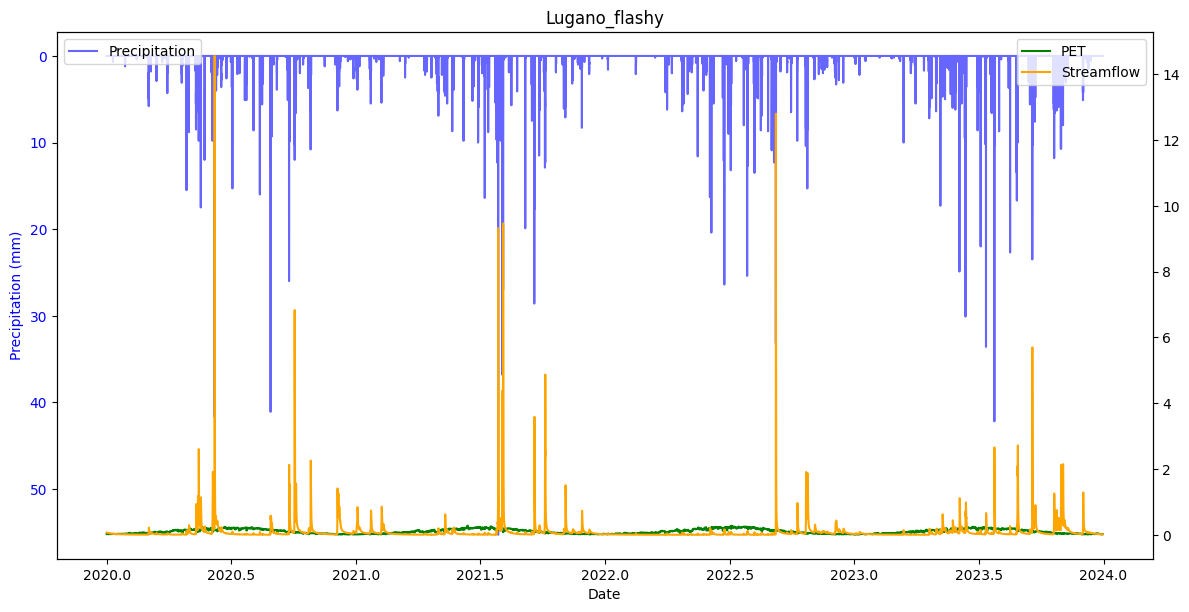

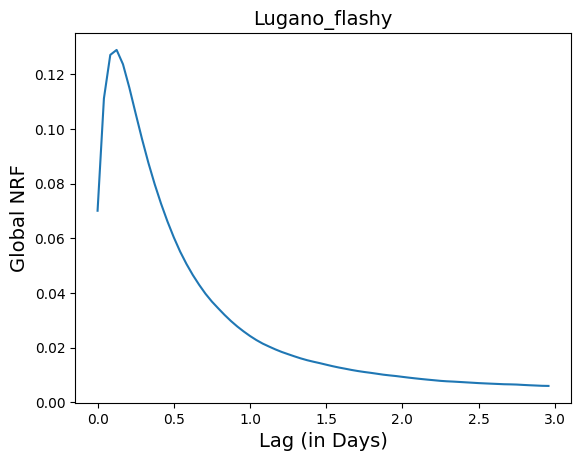

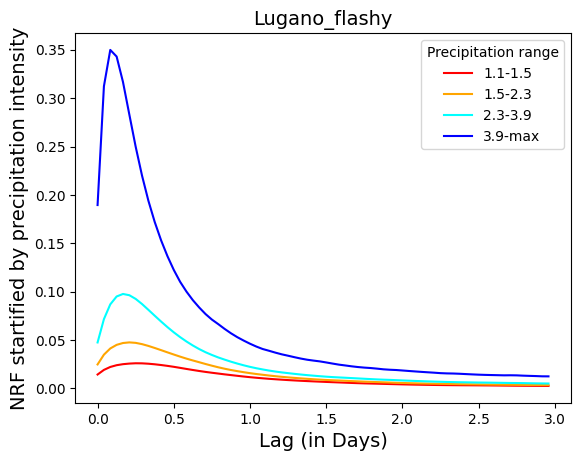

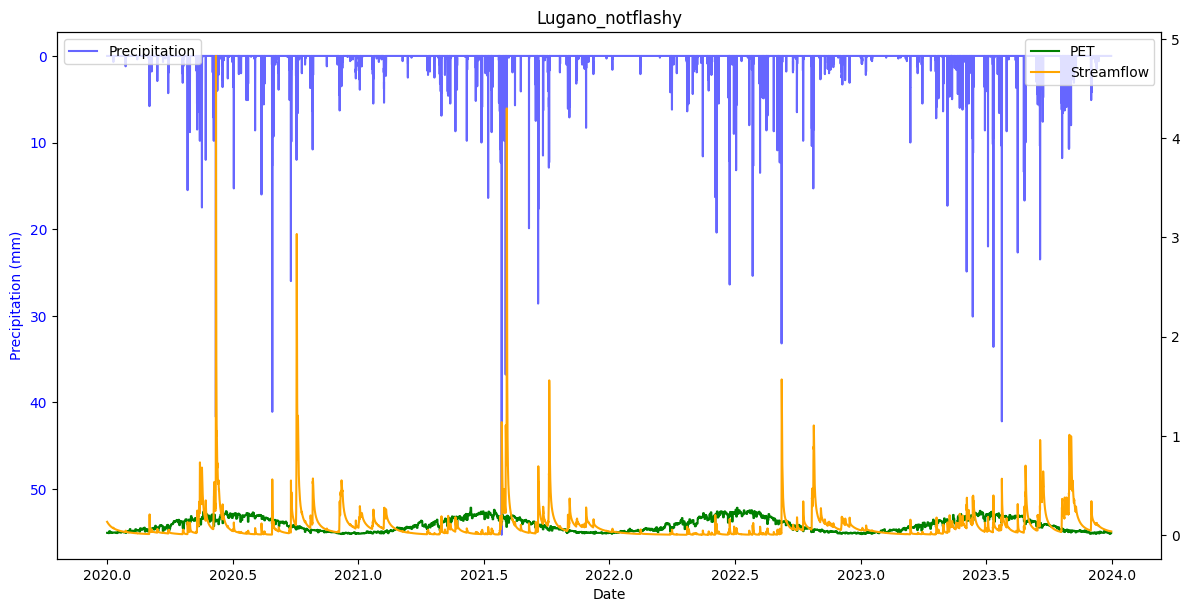

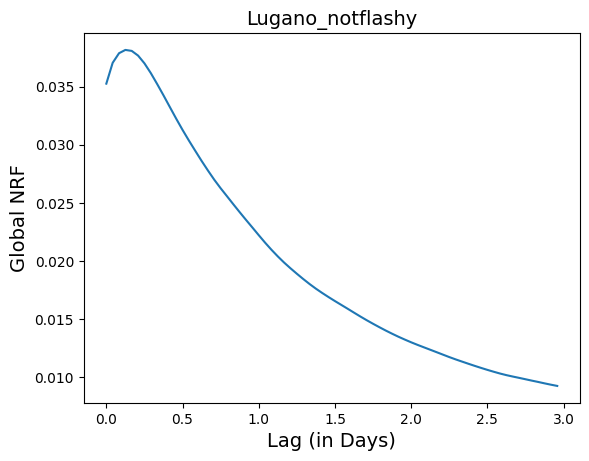

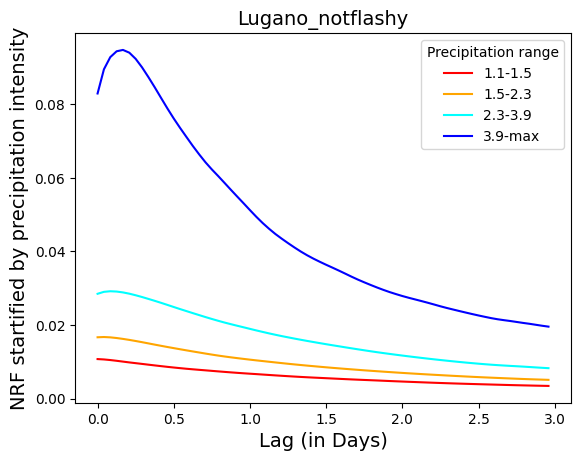

In [5]:
for station in ls_stations:
    for mode in ls_modes:
        site = '{0}_{1}'.format(station, mode)
        data = pd.read_csv('{0}_data.txt'.format(site))
        show_data(data, max_time_points=24*365*4, title=site)
        show_transfer_functions(data, site, max_lag=24*3, title=site)